# Correlated Preferences Simluation
### Tyler Hoppenfeld

This notebook is intended to explore the of idiosynchratic preferences on market behavior.

There are several research questions that seem to be derrivitave of this, in varying degrees of being well-formed:

1. How do we define "idiosynchratic preferences?"
2. How does our definition of idiosynchratic prefernces scale with market size?
3. What do idiosynchratic preferences mean for stable latice size?
4. What are the welfare implications of idiosynchratic preferences?
5. What is the result of a case where both sides have idiosynchratic preferences, but the preferences are correlated between sides (ie, if $M_i$ ranks $W_j$ unusually highly, then $W_j$ also ranks $M_i$ unusually highly)?
6. How do these market structures interact with limited-length rank lists?

This notebook proposes an ad-hoc answer to 1 and 2, and uses a simulation to hint at the answer to 3. 

To answer 1, I construct a standard marriage market with $N$ participants on each side, indexed ${M_1, M_2, ..., M_N, W_1, W_2,..., W_N}$

I next construct preferences in which all particpents are mutually acceptable.  I begin by assigning a utility to each matching based on the participant's index number, so each man gets $1$ unit of utility from being matched to $W_1$, $ 2$ units from being matched to $W_2$, and so on up to $N$ units of utility from being matched to $W_N$.  This process gives $2 \times N \times N$ utility values.

I then add a perturbation to each utility value.  The perturbation is drawn from  $N(0, \sigma \bar{U})$ where $\bar{U}$ is the average utility for that economy and $\sigma$ is the parameter that controlls the degree to which preferences are idiosynchratic.

To produce the final complete preference, I sort by these utilities.


Note two things:
* this structure assumes an answer the question of what it means to hold idiosynchracy constant while scaling the market.  
* expanding the economy in this model is equivilent to adding new entrants to the market without expanding the difference in utility from being matched to one's favorite or least-prefered partner

After constructing these preferences I use a 3rd-party python package to implement the Gale-Shaply algorythm twice, once with men proposing and once with women proposing.  

As a proxy for latice size, and following Al Roth's heuristic used in class, I calculate the fraction of agents who have a different partner in the man-optimal matching than in the woman-optimal matchng.


This procedure constitutes a simulation of the economy.  I simulate each $N/\sigma$ pair 100 times, averaging the results, and tabulate them below.

### Scroll to "Main Results" to bypass the code:

In [330]:
#Import packages used below

##Note that this is the old version of the matching package, "pip3 install matching==0.1.1"

from matching.algorithms import galeshapley
import operator
import random
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
##pip3 install multiprocess
import multiprocessing as mp 
import matplotlib.pyplot as plt
import itertools
import copy


In [331]:
#Set parameters 
#note that the parameters for N and sigma are set below within a program.
#This is bad form, but I don't know how to do it correctly, so i'm documenting the bad practice here.

runs = 100

In [332]:

#define simulation function that implements the process outlined in the text above
def GS_Sim(
    n ,
    sigma_fraction ,
    run_no
):

    #make randomly assigned preferences
    Mpref = {}
    Wpref = {}

    #determine padding length
    length = len(str(n))

    #scale sigma
    sigma = sigma_fraction * n /2

    for i in range(0, n):
        utility = []
        for x in range(0,n):
            id =  str(x).zfill(length)
            utility = utility + [(id, random.normalvariate(x, sigma))]
        utility.sort(key=operator.itemgetter(1))

        ranklist = []
        for x in utility:
            name = [x[0]]
            ranklist = ranklist + name
        id =  str(i).zfill(length)
        Mpref.update({id:ranklist})
    #copypasta from above
    for i in range(0, n):
        utility = []
        for x in range(0,n):
            id =  str(x).zfill(length)
            utility = utility + [(id, random.normalvariate(x, sigma))]
        utility.sort(key=operator.itemgetter(1))

        ranklist = []
        for x in utility:
            name = [x[0]]
            ranklist = ranklist + name
        id = str(i).zfill(length)
        Wpref.update({id:ranklist})




    #make dupes of the preferences, sicne galeshaply seems to fuck them up
    MprefDup = copy.deepcopy(Mpref)
    WprefDup = copy.deepcopy(Wpref)

    #Run matching
    M_propose= galeshapley(MprefDup, WprefDup)

    #extract "worst" rejecting suiter for each man
    LRRW_list = []
    for M, match in M_propose.items():
        #extract M's ranklist:
        ranklist = Mpref[M]

        #initialize lowest ranked rejecting woman as the non-existant "0" ranked woman
        LRRW = 0
        for w in ranklist:
            if int(w) == int(match) :
                break

            elif LRRW < int(w):
                LRRW = int(w)

        LRRW_list  = LRRW_list + [LRRW]



    #transform matchings into same-format list of tuples
    M_propose = list(M_propose.items())

    #make DataFrame 
    M_propose = pd.DataFrame(M_propose,columns=["Men", "W" + str(run_no)])

    #add on LRRW values
    M_propose["LRRW" + str(run_no)] = LRRW_list

    #make multiIndex
    M_propose['n'] = n
    M_propose['sigma'] = sigma_fraction
    
    M_propose = M_propose.set_index(['n','sigma','Men'])
    return M_propose
    




In [333]:
# an intermediate simulation program to allow me to parallelize the calculations
def simulate(run_no):
    #Note that, as noted above, I define the parameters here, within a program. This is bad.
    #Also note that the code in this block changes a bit as I add to the "results" object without 
    #re-running the entire simulation
    sizes = [10, 50, 500, 5000]
    sigmas = [.001,.005, .01,.05, .1, .3]
    #Slopyness ends here
    
    result = pd.DataFrame()
    for n in sizes:
        for sigma_fraction in sigmas:
            result = result.append(GS_Sim(n, sigma_fraction, run_no))
    
    return result



In [334]:


pool = mp.Pool(processes = (mp.cpu_count()))
results = pool.map(simulate, range(0,runs))
pool.close()
pool.join()

results_df = pd.concat(results, sort=True, axis = 1)
results_df

W0  LRRW0   W1  LRRW1   W2  LRRW2   W3  LRRW3   W4  LRRW4  \
n   sigma Men                                                               
10  0.001 00    00      0   00      0   00      0   00      0   00      0   
          01    01      0   01      0   01      0   01      0   01      0   
          02    02      1   02      1   02      1   02      1   02      1   
          03    03      2   03      2   03      2   03      2   03      2   
          04    04      3   04      3   04      3   04      3   04      3   
          05    05      4   05      4   05      4   05      4   05      4   
          06    06      5   06      5   06      5   06      5   06      5   
          07    07      6   07      6   07      6   07      6   07      6   
          08    08      7   08      7   08      7   08      7   08      7   
          09    09      8   09      8   09      8   09      8   09      8   
    0.005 00    00      0   00      0   00      0   00      0   00      0   
          01    01      0   01      0   01      0   01      0   01      0   
          02    02      1   02      1   02      1   02      1   02      1   
          03    03      2   03      2   03      2   03      2   03      2   
          04    04      3   04      3   04      3   04      3   04      3   
          05    05      4   05      4   05      4   05      4   05      4   
          06    06      5   06      5   06      5   06      5   06      5   
          07    07      6   07      6   07      6   07      6   07      6   
          08    08      7   08      7   08      7   08      7   08      7   
          09    09      8   09      8   09      8   09      8   09      8   
    0.010 00    00      0   00      0   00      0   00      0   00      0   
          01    01      0   01      0   01      0   01      0   01      0   
          02    02      1   02      1   02      1   02      1   02      1   
          03    03      2   03      2   03      2   03      2   03      2   
          04    04      3   04      3   04      3   04      3   04      3   
          05    05      4   05      4   05      4   05      4   05      4   
          06    06      5   06      5   06      5   06      5   06      5   
          07    07      6   07      6   07      6   07      6   07      6   
          08    08      7   08      7   08      7   08      7   08      7   
          09    09      8   09      8   09      8   09      8   09      8   
...            ...    ...  ...    ...  ...    ...  ...    ...  ...    ...   
500 0.300 470  437    488  475    486  449    490  495    472  441    401   
          471  464    488  446    478  391    490  458    453  413    390   
          472  388    456  418    496  382    305  489    404  494    447   
          473  495    484  452    490  371    401  475    463  476    492   
          474  359    484  466    489  430    458  480    402  326    479   
          475  498    487  481    492  489    463  459    499  435    442   
          476  416    486  487    489  359    340  479    463  466    396   
          477  476    432  474    494  479    499  473    499  470    430   
          478  302    341  351    464  423    340  461    488  473    483   
          479  497    487  462    489  475    467  471    487  396    451   
          480  480    457  489    486  491    467  285    383  314    383   
          481  401    456  428    472  497    495  477    475  474    470   
          482  487    480  455    470  414    317  464    442  485    498   
          483  357    465  360    490  488    471  490    497  496    414   
          484  482    493  488    490  418    461  486    452  426    429   
          485  433    497  443    486  459    379  483    499  491    486   
          486  475    479  388    472  495    492  436    482  499    476   
          487  414    477  497    483  397    436  413    484  493    461   
          488  472    471  495    492  463    464  478    480  381    390   
          48

In [354]:
res_num = results_df.apply(pd.to_numeric)


In [367]:
LRRW_df = res_num[[col for col in res_num.columns if col.startswith('LRRW')]]
deliverable = pd.DataFrame()
deliverable['mean'] = LRRW_df.mean(axis = 1)      
deliverable['q_05'] = LRRW_df.quantile(.05, axis = 1) 
deliverable['q_50'] = LRRW_df.quantile(.50, axis = 1) 
deliverable['q_95'] = LRRW_df.quantile(.95, axis = 1) 

deliverable = deliverable.reset_index().apply(pd.to_numeric)

deliverable['mean'] = deliverable['mean']-deliverable['Men']
deliverable['q_05'] = deliverable['q_05']-deliverable['Men']
deliverable['q_50'] = deliverable['q_50']-deliverable['Men']
deliverable['q_95'] = deliverable['q_95']-deliverable['Men']




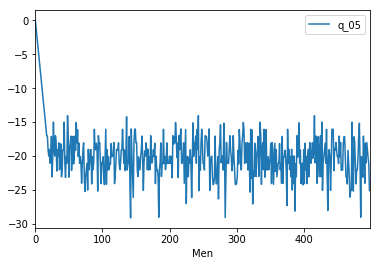

In [380]:
deliverable[(deliverable['n'] == 500)&(deliverable['sigma'] == .05)].plot(x='Men' ,y= 'q_05')


,n,sigma,Men,LRRW0,LRRW1,LRRW2,LRRW3,LRRW4,LRRW5,LRRW6,...,LRRW90,LRRW91,LRRW92,LRRW93,LRRW94,LRRW95,LRRW96,LRRW97,LRRW98,LRRW99
0,10,0.001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0.001,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0.001,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,10,0.001,3,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,10,0.001,4,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
5,10,0.001,5,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
6,10,0.001,6,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
7,10,0.001,7,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
8,10,0.001,8,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
9,10,0.001,9,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8


In [45]:

#flatten the list:

def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

flat_results = flatten(results) 

#Take group averages within the simulation
simulation_results = pd.DataFrame(flat_results,columns=['Market Size', 'Sigma','% Commonality' ])

gb = simulation_results.groupby(['Market Size','Sigma'])['% Commonality' ]

simulation_results['Commonality SD'] = gb.transform('std')
simulation_results['Simulation Count'] = gb.transform('count')
deliverable = simulation_results.groupby(['Market Size','Sigma'])['% Commonality' , 'Commonality SD', 'Simulation Count'].mean().reset_index()

deliverable

,Market Size,Sigma,% Commonality,Commonality SD,Simulation Count
0,10,0.001,1.000000,0.000000,1000
1,10,0.005,1.000000,0.000000,1000
2,10,0.010,1.000000,0.000000,1000
3,10,0.050,1.000000,0.000000,1000
4,10,0.100,0.987000,0.050927,1000
5,10,0.300,0.918400,0.125846,1000
6,50,0.001,1.000000,0.000000,1000
7,50,0.005,1.000000,0.000000,1000
8,50,0.010,0.999960,0.001265,1000
9,50,0.050,0.942360,0.048908,1000


NameError: name 'deliverable' is not defined

## Main Results:
The averaged results from the runs of this simulation for each parameter pair are plotted below. This suggests that there is not an obviously simple relationship between preference structure, market size, and the size of the core.

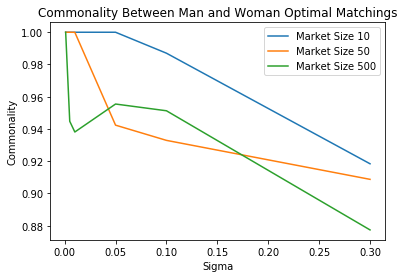

In [47]:
deliverable_10 = deliverable[deliverable['Market Size'] == 10]
deliverable_50 = deliverable[deliverable['Market Size'] == 50]
deliverable_500 = deliverable[deliverable['Market Size'] == 500]

plt.plot('Sigma', '% Commonality', data = deliverable_10, label = "Market Size 10")
plt.plot('Sigma', '% Commonality', data = deliverable_50, label = "Market Size 50")
plt.plot('Sigma', '% Commonality', data = deliverable_500, label = "Market Size 500")

plt.title("Commonality Between Man and Woman Optimal Matchings")
plt.xlabel('Sigma')
plt.ylabel('Commonality')
plt.legend()
plt.show()


### Data Structure Plot
To examine the structure of the data for the most interesting datapoints (size = 500, $\sigma$ = .01, .1), I form a histogram at those datapoints.  The averages do not appear to be driven by outliers, and they appear to have a similar data structure.

Text(0.5, 1.0, 'Distribution of Comonalities for Size = 500, Sigma = .01')

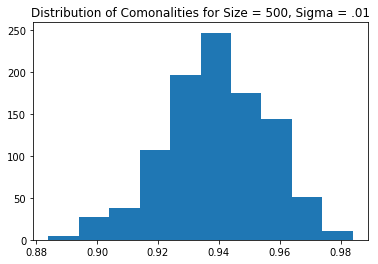

In [48]:
plt.hist(simulation_results[(simulation_results['Market Size']== 500 ) &(simulation_results['Sigma']== .01 )]['% Commonality'])
plt.title("Distribution of Comonalities for Size = 500, Sigma = .01")



Text(0.5, 1.0, 'Distribution of Comonalities for Size = 500, Sigma = .1')

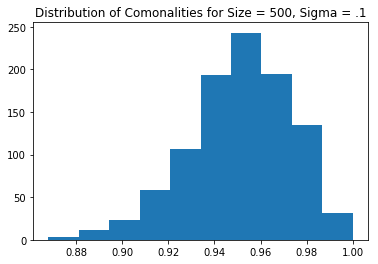

In [49]:
plt.hist(simulation_results[(simulation_results['Market Size']== 500 ) &(simulation_results['Sigma']== .1 )]['% Commonality'])
plt.title("Distribution of Comonalities for Size = 500, Sigma = .1")

## Granular results:
Finally, I show the basic summary statistics underlying the first plot:

In [50]:
deliverable

,Market Size,Sigma,% Commonality,Commonality SD,Simulation Count
0,10,0.001,1.000000,0.000000,1000
1,10,0.005,1.000000,0.000000,1000
2,10,0.010,1.000000,0.000000,1000
3,10,0.050,1.000000,0.000000,1000
4,10,0.100,0.987000,0.050927,1000
5,10,0.300,0.918400,0.125846,1000
6,50,0.001,1.000000,0.000000,1000
7,50,0.005,1.000000,0.000000,1000
8,50,0.010,0.999960,0.001265,1000
9,50,0.050,0.942360,0.048908,1000
